In [1]:
import numpy as np
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
import os

In [2]:
def F_kernel(q): 
    if q>=0 and q<1:
        return 1-1.5*q**2+0.75*q**3
    if q>=1 and q<2:
        return 0.25*(2-q)**3
    if q>=2:
        return 0

def F_kernel_p(q): 
    if q>=0 and q<1:
        return -3.*q + 3*0.75*q**2
    if q>=1 and q<2:
        return 0.75*(2-q)**2*(-1)
    if q>=2:
        return 0
    
def W_1order(dist, h):
    q = dist/h
    C = 2./3.
    return C*F_kernel(q)/h**1

def W_1order_p(ra, rb, h):
    q = abs(ra-rb)/h
    C = 2./3.
    if ra == rb: 
        rhat = 0
    else:
        rhat = (ra-rb)/abs(ra-rb)
    return rhat*C*F_kernel_p(q)/h**2

In [20]:
#16, 17

def get_density(particles, nghost = 0):
    n = len(particles)
    for i in range(nghost, n-nghost):
        particles[i, DEN] = 0
        for j in range(n):
            particles[i, DEN] += particles[j, MAS]*W_1order(abs(particles[i,X1]-particles[j,X1]), particles[i,LEN])
    return particles

def eos_iso(rho, cs = 1.0):
    p = cs**2*rho
    return p

def eos_adi(rho, u, gamma = 1.4):
    cs2 = (gamma - 1.)*u
    p = cs2*rho
    cs = np.sqrt(cs2)
    return p, cs

def get_pressure(particles, nghost, eos="adi"):
    n = len(particles)
    for i in range(nghost, n-nghost):
        if eos == "iso":
            particles[i, PRE] = eos_iso(particles[i, DEN], particles[i, SPE])
        elif eos == "adi":
            particles[i, PRE], particles[i, SPE] = eos_adi(particles[i, DEN], particles[i, ENE])
    return particles

def get_visco(para, parb, alpha = 1.5, beta = 2):
    vab = para[VEL1] - parb[VEL1]
    if para[X1] == parb[X1]: 
        rab_hat = 0
    else:
        rab_hat = (para[X1] - parb[X1])/abs(para[X1] - parb[X1])
    vdotr = vab*rab_hat
    if vdotr < 0:
        nu_siga = alpha * para[SPE] - beta*vdotr
        nu_sigb = alpha * parb[SPE] - beta*vdotr
        qa = -0.5*para[DEN]*nu_siga*vdotr
        qb = -0.5*parb[DEN]*nu_sigb*vdotr
    else:
        qa = 0
        qb = 0
    return qa, qb

def smoothing(particles):
    hfact = 2.0     #1.2 
    for i in range(len(particles)):
        particles[i, LEN] = hfact*(particles[i,MAS]/particles[i,DEN])
    return particles

def get_accel(particles, nghost):
    mass = particles[:,MAS]
    p = particles[:,PRE]
    rho = particles[:,DEN]
    r = particles[:,X1]
    h = particles[:,LEN]
    v = particles[:,VEL1]
    n = len(particles)
    for a in range(nghost, n-nghost):
        acc = 0
        accu = 0
        for b in range(n):
            qa, qb = get_visco(particles[a], particles[b])
            wha = W_1order_p(r[a], r[b], h[a])
            whb = W_1order_p(r[a], r[b], h[b])
            acc += - mass[b]*(  ((p[a]+qa)/rho[a]**2)*wha 
                              + ((p[b]+qb)/rho[b]**2)*whb )
            accu += mass[b]*((p[a]+qa)/rho[a])*(v[a]-v[b])*wha 
        particles[a, ACC1] = acc
        particles[a, ACCU] = accu
    return particles

def derivs(particles, nghost):
    n_smooth = 3
    particles = set_ghosts(particles, nghost, L)
    for i in range(n_smooth):
        particles = get_density(particles, nghost)
        particles = smoothing(particles)
    particles = get_pressure(particles, nghost)
    particles = get_accel(particles, nghost)
    particles = set_ghosts(particles, nghost, L)
    return particles

In [21]:
def integral(particles, nghost, dt):
    r = np.copy(particles[:,X1])
    vel = np.copy(particles[:,VEL1])
    u = np.copy(particles[:,ENE])
    vhalf = np.copy(vel)
    uhalf = np.copy(u)
    for a in range(nghost, len(particles)-nghost):
        particles[a, X1] = r[a] + dt*vel[a] + 0.5*dt**2*particles[a, ACC1]
        vhalf[a] = vel[a] + 0.5*dt*particles[a, ACC1]
        uhalf[a] = u[a] + 0.5*dt*particles[a, ACCU]
    particles = derivs(particles, nghost)
    for a in range(nghost, len(particles)-nghost):
        particles[a, VEL1] = vhalf[a] + 0.5*dt*particles[a, ACC1]
        particles[a, ENE] = uhalf[a] + 0.5*dt*particles[a, ACCU]
    return particles

In [22]:
# output data
def write_particles(particles, t, filename):
    with open(filename, 'w') as file:
        file.write(str(t) + '\n')
        for particle in particles:
            file.write(' '.join(map(str, particle)) + '\n')
            
def read_particles(filename):
    particles = []
    with open(filename, 'r') as file:
        lines = file.readlines()
        t = float(lines[0])
        for line in lines[1:]:
            particle = list(map(float, line.split()))
            particles.append(particle)
    return t, np.array(particles)

def write_time(filename, keys, values):
    if (abs(values[0] - 0) < 1e-6) and os.path.exists(filename):
        os.remove(filename)
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    file_exists = os.path.isfile(filename)
    with open(filename, 'a') as file:
        if not file_exists:
            # 写入表头
            for key in keys:
                file.write(key+"\t")
            file.write("\n")
        # 写入数据
        for value in values:
            file.write(str(value)+"\t")
        file.write("\n")
        

In [23]:
def get_kinetic_energy(particles, nghost):
    kn = 0
    for i in range(nghost, len(particles)-nghost):
        kn += 0.5*particles[i,MAS]*particles[i,VEL1]**2
    return kn

def sim(particles, nghost, t0, tmax, dt, dtoutput, output_path = "./"):
    t = t0
    output_index = 0
    toutput = t0
    keys = ["time", "kinetic energy"]
    
    print("t=", format(t, ".4f"), end="\r")
    write_time(output_path+"time.txt", keys, [t, get_kinetic_energy(particles, nghost)])
    filename = output_path+"output."+ str(output_index).zfill(5) + ".txt"
    write_particles(particles, t, filename)
    toutput = toutput + dtoutput
    output_index += 1
    while t < tmax:
        if t + dt >= tmax: 
            dt = tmax - t
            toutput = tmax
        t = t + dt
        particles = integral(particles, nghost, dt)
        particles = derivs(particles, nghost)
        write_time(output_path+"time.txt", keys, [t, get_kinetic_energy(particles, nghost)])
        if abs(t-toutput)<0.5*dt:
            print("t=", format(t, ".4f"), end="\r")
            filename = output_path+"output."+ str(output_index).zfill(5) + ".txt"
            write_particles(particles, t, filename)
            toutput = toutput + dtoutput
            output_index += 1
    return particles

In [24]:

X1 = 0      # position x1
VEL1 = 1    # velocity in x1 direction 
MAS = 2     # mass 
LEN = 3     # smoothing length
DEN = 4     # density
ENE = 5     # internal energy (u) 
PRE = 6     # pressure 
SPE = 7     # sound speed
ACC1 = 8    # acceleration for velosity
ACCU = 9    # acceleration for internal energy

def setup(nleft, x0, xmin, xmax, rholeft, rhoright, pleft, pright, nghost = 0):
    gamma = 1.4
    particles = np.zeros((nleft+nghost, 10))
    particle = np.copy(particles[0])
    dxleft = (x0 - xmin)/nleft
    m0 = rholeft*dxleft
    for i in range(len(particles)):
        particles[i, X1] = xmin + 0.5*dxleft + (i-nghost)*dxleft
        particles[i, DEN] = rholeft
        particles[i, MAS] = m0 
        particles[i, VEL1] = 0.
        particles[i, LEN] = 2.0*dxleft      # 1.2*dxleft
        particles[i, PRE] = pleft
        particles[i, ENE] = pleft/((gamma-1.)*rholeft)
    dxright = m0/rhoright
    x = x0 + 0.5*dxright
    while x <= xmax:
        particle[X1] = x
        particle[DEN] = rhoright
        particle[MAS] = m0 
        particle[VEL1] = 0.
        particle[LEN] = 2.0*dxright         # 1.2*dxright
        particle[PRE] = pright
        particle[ENE] = pright/((gamma-1.)*rhoright)
        particles = np.insert(particles, len(particles), particle, 0)
        x = x + dxright
    for i in range(nghost):
        particle[X1] = x
        particle[DEN] = rhoright
        particle[MAS] = m0 
        particle[VEL1] = 0.
        particle[LEN] = 2.0*dxright         # 1.2*dxright
        particle[PRE] = pright
        particle[ENE] = pright/((gamma-1.)*rhoright)
        particles = np.insert(particles, len(particles), particle, 0)
        x = x + dxright
    return particles

def set_ghosts(particles, nghost, L):
    for i in range(nghost):
        particles[i] = particles[i]
        particles[-nghost+i] = particles[-nghost+i]
    return particles

In [27]:
nleft = 200
xmin = - 0.2
xmax = 0.4
x0 = 0
L = xmax - xmin
rholeft = 1.0
rhoright = 0.125
pleft = 1.0
pright = 0.1
gamma = 1.4 #fake parameter, need to be changed in code
nghost = 6
particles = setup(nleft, x0, xmin, xmax, rholeft, rhoright, pleft, pright, nghost)
particles = get_accel(particles, nghost)

t0 = 0
tmax = 0.1
dt = 0.001
toutput = 0.
dtoutput = 0.005

t = t0

output_path = "./sod002/"
particles = sim(particles, nghost, t0, tmax, dt, dtoutput, output_path)

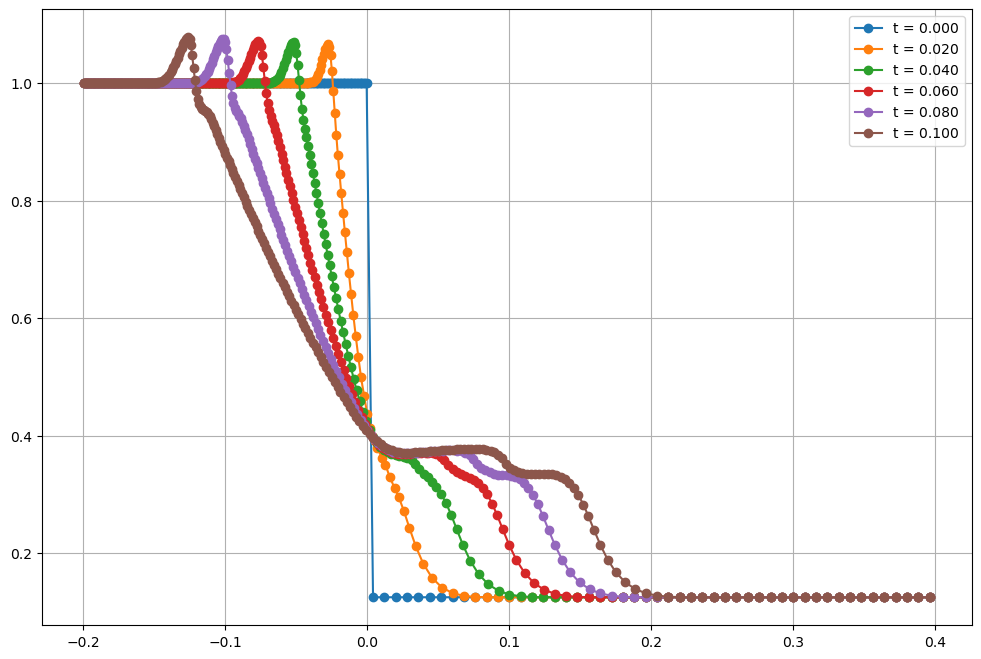

In [28]:
plt.figure(figsize = (12,8))
output_path = "./sod002/"
for i in range(0, 21, 4):
    filename = output_path+"output."+ str(i).zfill(5) + ".txt"
    t, particles = read_particles(filename)
    act_par = particles[nghost:-nghost]
    #plt.scatter(act_par[:, X1], act_par[:, DEN], label = "t = "+ format(t, ".3f"), s = 5)
    plt.plot(act_par[:, X1], act_par[:, DEN], label = "t = "+ format(t, ".3f"), marker = "o")
#plt.xlim(-0.05,0.05)
plt.grid()
plt.legend()
plt.show()

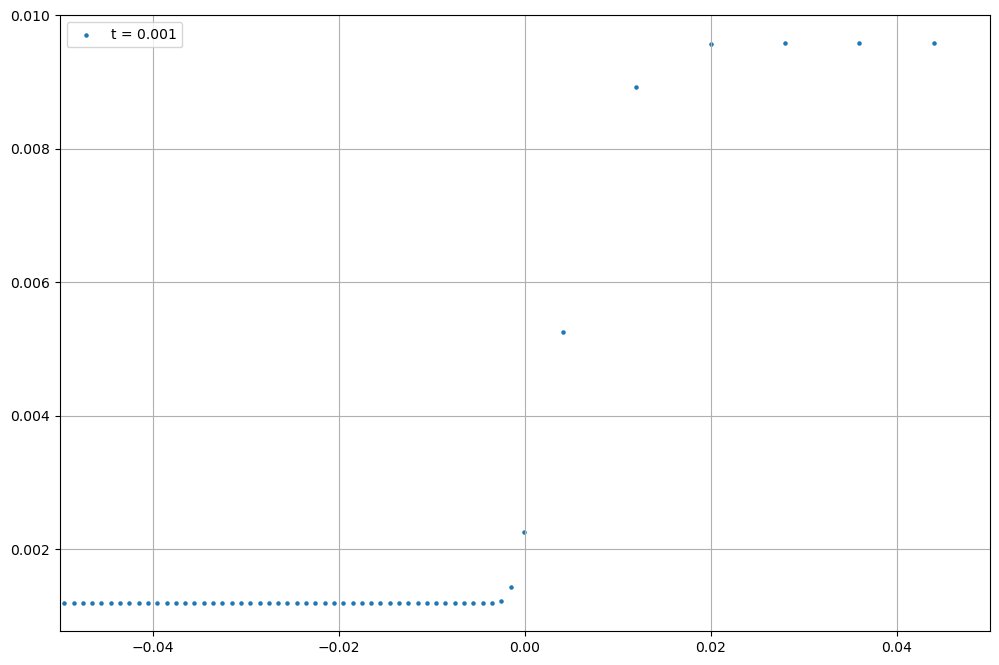

In [19]:
plt.figure(figsize = (12,8))
output_path = "./sod002/"
i = 1
filename = output_path+"output."+ str(i).zfill(5) + ".txt"
t, particles = read_particles(filename)
act_par = particles[nghost:-nghost]
plt.scatter(act_par[:, X1], act_par[:, LEN], label = "t = "+ format(t, ".3f"), s = 5)
plt.xlim(-0.05,0.05)
plt.grid()
plt.legend()
plt.show()